In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169

###
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Distiller Class

In [7]:
# Define the distiller model by gpt
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            ) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Creating Teacher and Student Model

In [11]:
DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the teacher model
teacher = models.Sequential([
    DenseNet169,                  # DenseNet base model
    layers.GlobalAveragePooling2D(),    # Reduces dimensionality (spatial pooling)
    layers.Dropout(0.2),                # Dropout to prevent overfitting
    layers.Dense(1024, activation='relu'), # Fully connected layer with ReLU activation
    layers.Dropout(0.2),                # Dropout
    layers.Dense(512, activation='relu'),  # Another dense layer with ReLU
    layers.Dense(5, activation='softmax')  # Final output layer (assuming 5 classes)
])

# Create the student model
student = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(5, activation='softmax')
])

student.summary()

# Clone the student model for scratch training comparison
student_scratch = models.clone_model(student)

# Image data generators
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_118 (Conv2D)             │ (None, 112, 112, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 7, 7, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 2, 2, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 600)            │        39,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 5)              │           755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,293 (1.76 MB)

 Trainable params: 460,293 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


Train the Teacher Network and Distill the Teacher weights to Student

In [12]:
import tensorflow as tf
from tensorflow import keras # Import the keras module

#Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-06 22:30:00.478996:

92/92 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - sparse_categorical_accuracy: 0.4857 - distillation_loss: 0.0097 - loss: 0.2000 - student_loss: 1.2883 - val_sparse_categorical_accuracy: 0.6279 - val_loss: 0.2000 - val_student_loss: 1.0714
Epoch 2/25


2024-09-06 22:38:06.271856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 22:38:18.501570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - sparse_categorical_accuracy: 0.6527 - distillation_loss: 0.0186 - loss: 0.2000 - student_loss: 1.0248 - val_sparse_categorical_accuracy: 0.6977 - val_loss: 0.2000 - val_student_loss: 0.8337
Epoch 3/25


2024-09-06 22:45:48.379846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-06 22:45:56.289078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - sparse_categorical_accuracy: 0.7017 - distillation_loss: 0.0198 - loss: 0.2000 - student_loss: 0.9464 - val_sparse_categorical_accuracy: 0.6731 - val_loss: 0.2000 - val_student_loss: 0.7467
Epoch 4/25


2024-09-06 22:53:18.890807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 22:53:30.223641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 442s 5s/step - sparse_categorical_accuracy: 0.7074 - distillation_loss: 0.0200 - loss: 0.2000 - student_loss: 0.9329 - val_sparse_categorical_accuracy: 0.7086 - val_loss: 0.2000 - val_student_loss: 0.7768
Epoch 5/25


2024-09-06 23:00:40.878787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:00:51.309615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - sparse_categorical_accuracy: 0.7160 - distillation_loss: 0.0199 - loss: 0.2000 - student_loss: 0.9306 - val_sparse_categorical_accuracy: 0.7073 - val_loss: 0.2000 - val_student_loss: 0.8541
Epoch 6/25


2024-09-06 23:08:19.668190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:08:29.887679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - sparse_categorical_accuracy: 0.7062 - distillation_loss: 0.0199 - loss: 0.2000 - student_loss: 0.9211 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 0.9167
Epoch 7/25


2024-09-06 23:15:58.536547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:16:09.539728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - sparse_categorical_accuracy: 0.7144 - distillation_loss: 0.0203 - loss: 0.2000 - student_loss: 0.9158 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.9675
Epoch 8/25


2024-09-06 23:23:39.984398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:23:50.556913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 473s 5s/step - sparse_categorical_accuracy: 0.7379 - distillation_loss: 0.0202 - loss: 0.2000 - student_loss: 0.9153 - val_sparse_categorical_accuracy: 0.7155 - val_loss: 0.2000 - val_student_loss: 0.8636
Epoch 9/25


2024-09-06 23:31:32.526645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:31:42.717852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - sparse_categorical_accuracy: 0.7165 - distillation_loss: 0.0204 - loss: 0.2000 - student_loss: 0.9009 - val_sparse_categorical_accuracy: 0.6689 - val_loss: 0.2000 - val_student_loss: 0.8489
Epoch 10/25


2024-09-06 23:39:08.487603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:39:20.140210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - sparse_categorical_accuracy: 0.7042 - distillation_loss: 0.0208 - loss: 0.2000 - student_loss: 0.8924 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 0.7375
Epoch 11/25


2024-09-06 23:46:36.676465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:46:48.021023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 451s 5s/step - sparse_categorical_accuracy: 0.7125 - distillation_loss: 0.0203 - loss: 0.2000 - student_loss: 0.9052 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 0.9121
Epoch 12/25


2024-09-06 23:54:08.443064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 23:54:20.141050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 453s 5s/step - sparse_categorical_accuracy: 0.7144 - distillation_loss: 0.0213 - loss: 0.2000 - student_loss: 0.8863 - val_sparse_categorical_accuracy: 0.6990 - val_loss: 0.2000 - val_student_loss: 0.9072
Epoch 13/25


2024-09-07 00:01:41.488813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 00:01:52.428781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - sparse_categorical_accuracy: 0.7301 - distillation_loss: 0.0202 - loss: 0.2000 - student_loss: 0.9002 - val_sparse_categorical_accuracy: 0.7168 - val_loss: 0.2000 - val_student_loss: 0.8671
Epoch 14/25


2024-09-07 00:09:11.810088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 00:09:24.196335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - sparse_categorical_accuracy: 0.7142 - distillation_loss: 0.0210 - loss: 0.2000 - student_loss: 0.8886 - val_sparse_categorical_accuracy: 0.7223 - val_loss: 0.2000 - val_student_loss: 0.8856
Epoch 15/25


2024-09-07 00:17:22.881891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 00:17:35.328327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 1854s 20s/step - sparse_categorical_accuracy: 0.7274 - distillation_loss: 0.0208 - loss: 0.2000 - student_loss: 0.8904 - val_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2000 - val_student_loss: 0.7933
Epoch 16/25


2024-09-07 00:48:18.015593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 00:48:29.636543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - sparse_categorical_accuracy: 0.7340 - distillation_loss: 0.0211 - loss: 0.2000 - student_loss: 0.8773 - val_sparse_categorical_accuracy: 0.7004 - val_loss: 0.2000 - val_student_loss: 0.7892
Epoch 17/25


2024-09-07 00:55:46.144972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 00:55:56.694008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - sparse_categorical_accuracy: 0.7210 - distillation_loss: 0.0208 - loss: 0.2000 - student_loss: 0.8874 - val_sparse_categorical_accuracy: 0.6963 - val_loss: 0.2000 - val_student_loss: 0.8342
Epoch 18/25


2024-09-07 01:03:46.393627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:03:57.227454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - sparse_categorical_accuracy: 0.7231 - distillation_loss: 0.0211 - loss: 0.2000 - student_loss: 0.8849 - val_sparse_categorical_accuracy: 0.7073 - val_loss: 0.2000 - val_student_loss: 0.5891
Epoch 19/25


2024-09-07 01:11:27.044487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:11:39.015293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - sparse_categorical_accuracy: 0.7300 - distillation_loss: 0.0210 - loss: 0.2000 - student_loss: 0.8772 - val_sparse_categorical_accuracy: 0.7168 - val_loss: 0.2000 - val_student_loss: 0.9584
Epoch 20/25


2024-09-07 01:19:05.890370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:19:18.586468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - sparse_categorical_accuracy: 0.7218 - distillation_loss: 0.0214 - loss: 0.2000 - student_loss: 0.8821 - val_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2000 - val_student_loss: 1.1821
Epoch 21/25


2024-09-07 01:27:20.552789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:27:32.075096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - sparse_categorical_accuracy: 0.7042 - distillation_loss: 0.0206 - loss: 0.2000 - student_loss: 0.8866 - val_sparse_categorical_accuracy: 0.7168 - val_loss: 0.2000 - val_student_loss: 0.7721
Epoch 22/25


2024-09-07 01:34:43.079371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:34:54.842084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - sparse_categorical_accuracy: 0.7124 - distillation_loss: 0.0212 - loss: 0.2000 - student_loss: 0.8770 - val_sparse_categorical_accuracy: 0.7223 - val_loss: 0.2000 - val_student_loss: 0.8929
Epoch 23/25


2024-09-07 01:42:19.194192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:42:30.422344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - sparse_categorical_accuracy: 0.7376 - distillation_loss: 0.0210 - loss: 0.2000 - student_loss: 0.8768 - val_sparse_categorical_accuracy: 0.7182 - val_loss: 0.2000 - val_student_loss: 0.9045
Epoch 24/25


2024-09-07 01:49:27.779810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:49:40.226259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - sparse_categorical_accuracy: 0.7079 - distillation_loss: 0.0210 - loss: 0.2000 - student_loss: 0.8719 - val_sparse_categorical_accuracy: 0.7182 - val_loss: 0.2000 - val_student_loss: 1.0594
Epoch 25/25


2024-09-07 01:56:35.036312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-07 01:56:46.605435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - sparse_categorical_accuracy: 0.7298 - distillation_loss: 0.0214 - loss: 0.2000 - student_loss: 0.8643 - val_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2000 - val_student_loss: 0.8282


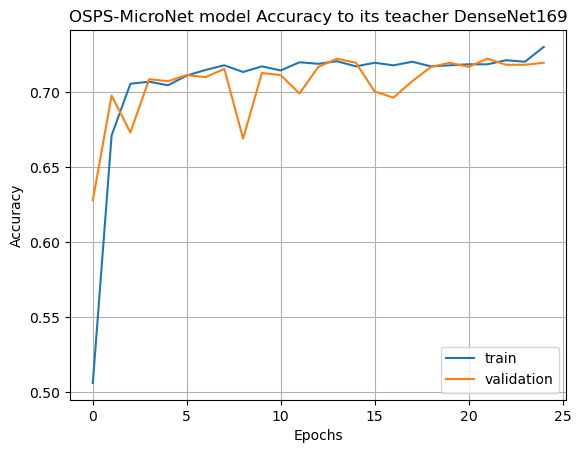

In [13]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher DenseNet169')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [14]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher DenseNet169 model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher DenseNet169 model is 72.22982048988342
